# Indirect Object Identification (IOI) Circuit Replication

This notebook replicates the IOI circuit from "Interpretability in the Wild" (Wang et al. 2022) on GPT2-small.

## Overview
The IOI task involves sentences like "When John and Mary went to the store, John gave a drink to" where the model should predict "Mary" (the indirect object) rather than "John".

In [1]:
import torch
import numpy as np
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/home/alex/environments/mech_interp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Packages imported successfully!
PyTorch version: 2.9.0+cu128
CUDA available: False


## Load GPT2-Small Model

In [2]:
# Load GPT2-small with TransformerLens
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)

print(f"Model loaded: {model.cfg.model_name}")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Number of heads: {model.cfg.n_heads}")
print(f"Hidden size: {model.cfg.d_model}")
print(f"Vocabulary size: {model.cfg.d_vocab}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
Model loaded: gpt2
Number of layers: 12
Number of heads: 12
Hidden size: 768
Vocabulary size: 50257


## Create IOI Dataset

The IOI task uses templates like:
- **ABBA**: "When John and Mary went to the store, John gave a drink to [MARY]"
- The model should predict the indirect object (Mary) not the repeated subject (John)

In [3]:
# Define IOI prompt templates and components
NAMES = [
    "Michael", "Christopher", "Jessica", "Matthew", "Ashley", "Jennifer", "Joshua", 
    "Amanda", "Daniel", "David", "James", "Robert", "John", "Mary", "William", "Linda"
]

PLACES = ["store", "park", "restaurant", "school", "office", "garden", "beach"]
OBJECTS = ["drink", "gift", "book", "letter", "message", "package", "card"]

# Template structure following the IOI paper
TEMPLATES = [
    "When {A} and {B} went to the {PLACE}, {S} gave a {OBJECT} to",
    "Then, {A} and {B} went to the {PLACE}, {S} gave a {OBJECT} to",
    "When {A} and {B} had a long argument, {S} gave a {OBJECT} to",
    "After {A} and {B} went to the {PLACE}, {S} gave a {OBJECT} to",
]

def generate_ioi_prompts(n_prompts=100, seed=42):
    """Generate IOI prompts with ABBA structure"""
    np.random.seed(seed)
    prompts = []
    
    for i in range(n_prompts):
        # Randomly select two different names
        name_pair = np.random.choice(NAMES, size=2, replace=False)
        A, B = name_pair[0], name_pair[1]
        
        # ABBA: A is mentioned first, then repeated, answer should be B
        template = np.random.choice(TEMPLATES)
        place = np.random.choice(PLACES)
        obj = np.random.choice(OBJECTS)
        
        prompt = template.format(A=A, B=B, S=A, PLACE=place, OBJECT=obj)
        
        prompts.append({
            'prompt': prompt,
            'IO': B,  # Indirect Object (correct answer)
            'S': A,   # Subject (repeated name, incorrect)
            'template': template,
        })
    
    return prompts

# Generate prompts
ioi_prompts = generate_ioi_prompts(n_prompts=50)

# Display first few examples
print("Sample IOI Prompts:\n")
for i in range(5):
    print(f"{i+1}. {ioi_prompts[i]['prompt']}")
    print(f"   -> Correct answer (IO): {ioi_prompts[i]['IO']}")
    print(f"   -> Wrong answer (S): {ioi_prompts[i]['S']}\n")

Sample IOI Prompts:

1. When Michael and Christopher went to the park, Michael gave a letter to
   -> Correct answer (IO): Christopher
   -> Wrong answer (S): Michael

2. Then, Linda and Amanda went to the school, Linda gave a letter to
   -> Correct answer (IO): Amanda
   -> Wrong answer (S): Linda

3. After David and Christopher went to the store, David gave a letter to
   -> Correct answer (IO): Christopher
   -> Wrong answer (S): David

4. Then, Robert and James went to the store, Robert gave a letter to
   -> Correct answer (IO): James
   -> Wrong answer (S): Robert

5. Then, Michael and Jessica went to the school, Michael gave a package to
   -> Correct answer (IO): Jessica
   -> Wrong answer (S): Michael



## Test Model Performance on IOI Task

IOI Task Performance:
  Accuracy: 47/50 = 94.0%
  Mean logit diff: 3.062
  Std logit diff: 2.076


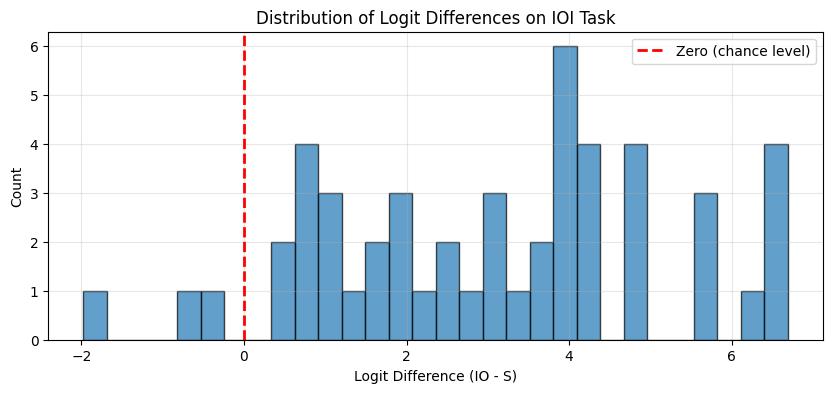


Positive logit diff means model prefers IO (correct answer)


In [4]:
def get_logit_diff(model, prompts):
    """
    Calculate the logit difference between IO and S tokens.
    Positive logit diff means model prefers IO (correct).
    """
    logit_diffs = []
    io_correct = 0
    
    for prompt_dict in prompts:
        prompt = prompt_dict['prompt']
        io_name = prompt_dict['IO']
        s_name = prompt_dict['S']
        
        # Get model predictions
        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits = model(tokens)
        
        # Get logits for the last position
        final_logits = logits[0, -1, :]
        
        # Get token IDs for IO and S names (use first token of each name)
        io_tokens = model.to_tokens(io_name, prepend_bos=False)[0]
        s_tokens = model.to_tokens(s_name, prepend_bos=False)[0]
        
        io_token = io_tokens[0]
        s_token = s_tokens[0]
        
        # Calculate logit difference
        logit_diff = final_logits[io_token].item() - final_logits[s_token].item()
        logit_diffs.append(logit_diff)
        
        # Check if IO has higher probability
        if final_logits[io_token] > final_logits[s_token]:
            io_correct += 1
    
    return logit_diffs, io_correct

# Test on IOI prompts
logit_diffs, io_correct = get_logit_diff(model, ioi_prompts)

print(f"IOI Task Performance:")
print(f"  Accuracy: {io_correct}/{len(ioi_prompts)} = {100*io_correct/len(ioi_prompts):.1f}%")
print(f"  Mean logit diff: {np.mean(logit_diffs):.3f}")
print(f"  Std logit diff: {np.std(logit_diffs):.3f}")

# Visualize
plt.figure(figsize=(10, 4))
plt.hist(logit_diffs, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (chance level)')
plt.xlabel('Logit Difference (IO - S)')
plt.ylabel('Count')
plt.title('Distribution of Logit Differences on IOI Task')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\nPositive logit diff means model prefers IO (correct answer)")

## Identify Circuit Components

The IOI circuit consists of several key head types:
1. **Name Mover Heads**: Copy the IO token to the final position
2. **S-Inhibition Heads**: Suppress the repeated subject name
3. **Duplicate Token Heads**: Detect repeated names

### 1. Identify Name Mover Heads

Name Mover Heads attend from the final position to the IO token and have high impact on the logit diff.

In [5]:
def analyze_attention_patterns(model, prompt_dict, layer=None, head=None):
    """
    Analyze attention patterns for a given prompt.
    Returns attention patterns and token positions.
    """
    prompt = prompt_dict['prompt']
    io_name = prompt_dict['IO']
    s_name = prompt_dict['S']
    
    # Tokenize
    tokens = model.to_tokens(prompt, prepend_bos=True)
    str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
    
    # Find positions of IO and S tokens
    io_pos = None
    s_pos = None
    s2_pos = None  # Second occurrence of S
    
    for i, tok in enumerate(str_tokens):
        if io_name in tok and io_pos is None:
            io_pos = i
        elif s_name in tok:
            if s_pos is None:
                s_pos = i
            elif s2_pos is None:
                s2_pos = i
    
    # Run model with cache
    logits, cache = model.run_with_cache(tokens)
    
    return {
        'tokens': tokens,
        'str_tokens': str_tokens,
        'io_pos': io_pos,
        's_pos': s_pos,
        's2_pos': s2_pos,
        'cache': cache,
        'logits': logits
    }

# Analyze a sample prompt
sample_data = analyze_attention_patterns(model, ioi_prompts[0])

print(f"Prompt: {ioi_prompts[0]['prompt']}")
print(f"\nTokens: {sample_data['str_tokens']}")
print(f"\nIO ('{ioi_prompts[0]['IO']}') position: {sample_data['io_pos']}")
print(f"S ('{ioi_prompts[0]['S']}') first position: {sample_data['s_pos']}")
print(f"S ('{ioi_prompts[0]['S']}') second position: {sample_data['s2_pos']}")
print(f"\nFinal token position: {len(sample_data['str_tokens']) - 1}")

Prompt: When Michael and Christopher went to the park, Michael gave a letter to

Tokens: ['<|endoftext|>', 'When', ' Michael', ' and', ' Christopher', ' went', ' to', ' the', ' park', ',', ' Michael', ' gave', ' a', ' letter', ' to']

IO ('Christopher') position: 4
S ('Michael') first position: 2
S ('Michael') second position: 10

Final token position: 14


In [6]:
def get_attention_to_io(model, prompts, top_k=10):
    """
    Find heads that attend most strongly from final position to IO position.
    These are candidate Name Mover Heads.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    
    # Track attention scores for each head
    attention_scores = np.zeros((n_layers, n_heads))
    
    for prompt_dict in prompts:
        data = analyze_attention_patterns(model, prompt_dict)
        
        if data['io_pos'] is None:
            continue
            
        final_pos = len(data['str_tokens']) - 1
        io_pos = data['io_pos']
        
        # Get attention patterns from final position to IO position
        for layer in range(n_layers):
            attn_pattern = data['cache']['pattern', layer][0]  # [head, dest, src]
            
            for head in range(n_heads):
                # Attention from final position to IO position
                attn_score = attn_pattern[head, final_pos, io_pos].item()
                attention_scores[layer, head] += attn_score
    
    # Average across prompts
    attention_scores /= len(prompts)
    
    # Find top heads
    flat_scores = attention_scores.flatten()
    flat_indices = np.argsort(flat_scores)[::-1][:top_k]
    
    top_heads = []
    for idx in flat_indices:
        layer = idx // n_heads
        head = idx % n_heads
        score = attention_scores[layer, head]
        top_heads.append((layer, head, score))
    
    return attention_scores, top_heads

# Find Name Mover Head candidates
attn_scores, top_heads = get_attention_to_io(model, ioi_prompts[:20], top_k=15)

print("Top heads attending from final position to IO position:")
print("(These are candidate Name Mover Heads)\n")
print(f"{'Layer':<6} {'Head':<6} {'Avg Attention':<15}")
print("-" * 30)
for layer, head, score in top_heads:
    print(f"{layer:<6} {head:<6} {score:<15.4f}")

Top heads attending from final position to IO position:
(These are candidate Name Mover Heads)

Layer  Head   Avg Attention  
------------------------------
9      9      0.8130         
10     7      0.7485         
9      6      0.6578         
11     10     0.6272         
10     0      0.5023         
9      8      0.3757         
10     10     0.3664         
10     6      0.3173         
10     1      0.3052         
10     2      0.2889         
10     3      0.2825         
9      0      0.2276         
8      3      0.2234         
11     6      0.1419         
8      10     0.1266         


### Visualize Name Mover Head Attention Patterns

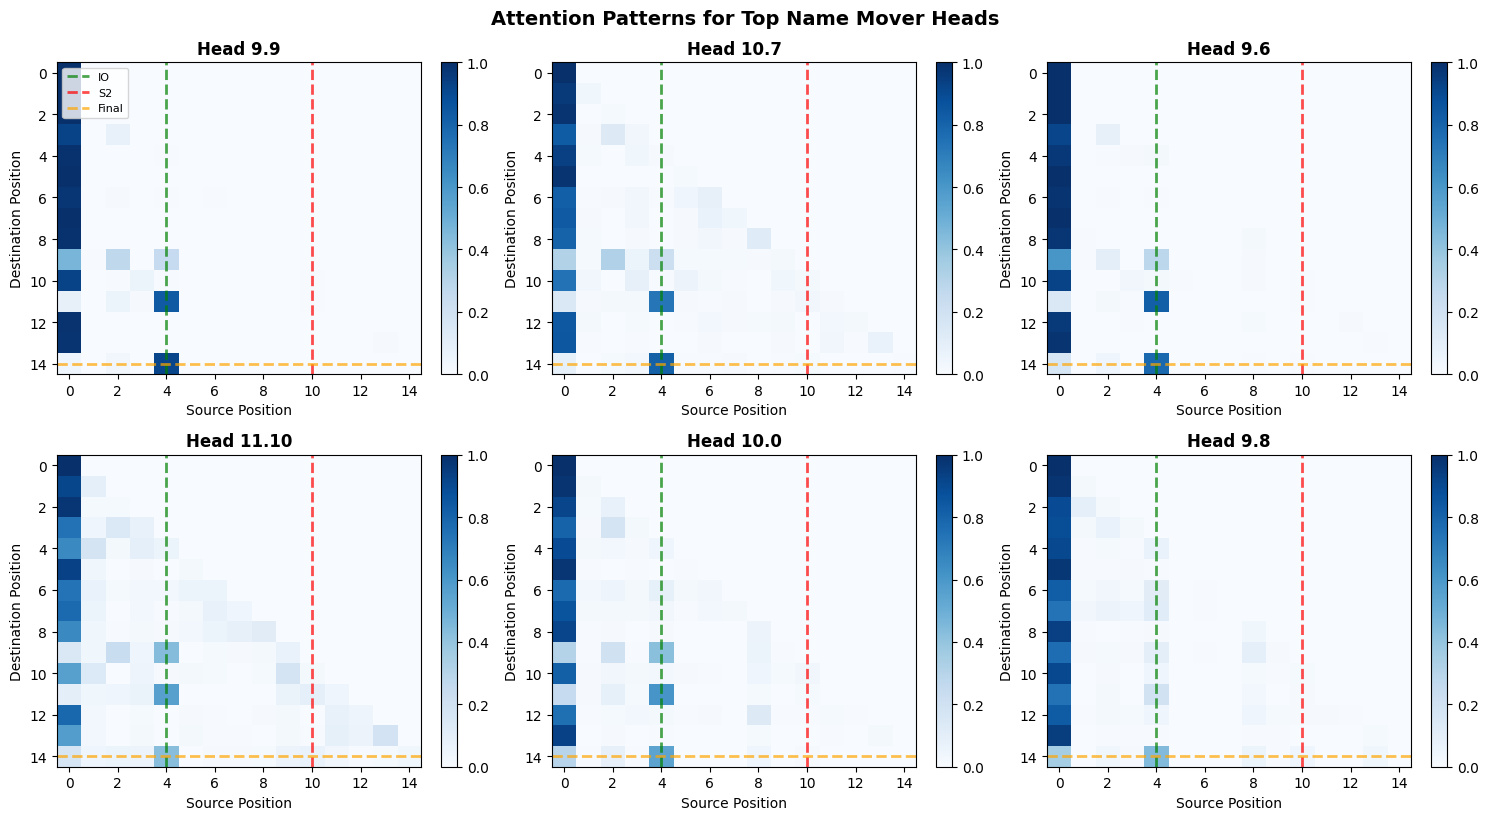

Green line: IO position (4)
Red line: S2 position (10)
Orange line: Final position (14)


In [7]:
# Visualize attention patterns for top Name Mover Heads
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

sample_prompt = ioi_prompts[0]
data = analyze_attention_patterns(model, sample_prompt)

top_name_mover_heads = [(9, 9), (10, 7), (9, 6), (11, 10), (10, 0), (9, 8)]

for idx, (layer, head) in enumerate(top_name_mover_heads):
    ax = axes[idx]
    
    # Get attention pattern
    attn_pattern = data['cache']['pattern', layer][0, head].detach().cpu().numpy()
    
    # Plot
    im = ax.imshow(attn_pattern, cmap='Blues', aspect='auto')
    ax.set_title(f'Head {layer}.{head}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Source Position')
    ax.set_ylabel('Destination Position')
    
    # Mark IO and S positions
    io_pos = data['io_pos']
    s2_pos = data['s2_pos']
    final_pos = len(data['str_tokens']) - 1
    
    # Highlight IO column
    ax.axvline(io_pos, color='green', linestyle='--', linewidth=2, alpha=0.7, label='IO')
    # Highlight S2 column
    ax.axvline(s2_pos, color='red', linestyle='--', linewidth=2, alpha=0.7, label='S2')
    # Highlight final row
    ax.axhline(final_pos, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Final')
    
    plt.colorbar(im, ax=ax, fraction=0.046)
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.suptitle('Attention Patterns for Top Name Mover Heads', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"Green line: IO position ({data['io_pos']})")
print(f"Red line: S2 position ({data['s2_pos']})")
print(f"Orange line: Final position ({len(data['str_tokens']) - 1})")

### 2. Identify S-Inhibition Heads

S-Inhibition Heads attend from the final position to the repeated subject (S2) and suppress its logits.

In [8]:
def get_attention_to_s2(model, prompts, top_k=10):
    """
    Find heads that attend from final position to S2 (repeated subject) position.
    These are candidate S-Inhibition Heads.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    
    attention_scores = np.zeros((n_layers, n_heads))
    
    for prompt_dict in prompts:
        data = analyze_attention_patterns(model, prompt_dict)
        
        if data['s2_pos'] is None:
            continue
            
        final_pos = len(data['str_tokens']) - 1
        s2_pos = data['s2_pos']
        
        for layer in range(n_layers):
            attn_pattern = data['cache']['pattern', layer][0]
            
            for head in range(n_heads):
                attn_score = attn_pattern[head, final_pos, s2_pos].item()
                attention_scores[layer, head] += attn_score
    
    attention_scores /= len(prompts)
    
    # Find top heads
    flat_scores = attention_scores.flatten()
    flat_indices = np.argsort(flat_scores)[::-1][:top_k]
    
    top_heads = []
    for idx in flat_indices:
        layer = idx // n_heads
        head = idx % n_heads
        score = attention_scores[layer, head]
        top_heads.append((layer, head, score))
    
    return attention_scores, top_heads

# Find S-Inhibition Head candidates
s_attn_scores, top_s_heads = get_attention_to_s2(model, ioi_prompts[:20], top_k=15)

print("Top heads attending from final position to S2 position:")
print("(These are candidate S-Inhibition Heads)\n")
print(f"{'Layer':<6} {'Head':<6} {'Avg Attention':<15}")
print("-" * 30)
for layer, head, score in top_s_heads:
    print(f"{layer:<6} {head:<6} {score:<15.4f}")

Top heads attending from final position to S2 position:
(These are candidate S-Inhibition Heads)

Layer  Head   Avg Attention  
------------------------------
8      6      0.8272         
7      9      0.4315         
8      10     0.3827         
8      5      0.3381         
9      7      0.2184         
7      3      0.1783         
3      6      0.1758         
6      0      0.1512         
8      2      0.1462         
11     8      0.1440         
4      3      0.1082         
2      7      0.1042         
1      10     0.0854         
2      3      0.0800         
11     0      0.0788         


### 3. Identify Duplicate Token Heads

Duplicate Token Heads detect when a token appears twice in the sequence. They attend from S2 to S1.

In [9]:
def get_duplicate_token_attention(model, prompts, top_k=10):
    """
    Find heads that attend from S2 position to S1 position.
    These are candidate Duplicate Token Heads.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    
    attention_scores = np.zeros((n_layers, n_heads))
    
    for prompt_dict in prompts:
        data = analyze_attention_patterns(model, prompt_dict)
        
        if data['s_pos'] is None or data['s2_pos'] is None:
            continue
            
        s1_pos = data['s_pos']
        s2_pos = data['s2_pos']
        
        for layer in range(n_layers):
            attn_pattern = data['cache']['pattern', layer][0]
            
            for head in range(n_heads):
                # Attention from S2 to S1
                attn_score = attn_pattern[head, s2_pos, s1_pos].item()
                attention_scores[layer, head] += attn_score
    
    attention_scores /= len(prompts)
    
    # Find top heads
    flat_scores = attention_scores.flatten()
    flat_indices = np.argsort(flat_scores)[::-1][:top_k]
    
    top_heads = []
    for idx in flat_indices:
        layer = idx // n_heads
        head = idx % n_heads
        score = attention_scores[layer, head]
        top_heads.append((layer, head, score))
    
    return attention_scores, top_heads

# Find Duplicate Token Head candidates
dup_attn_scores, top_dup_heads = get_duplicate_token_attention(model, ioi_prompts[:20], top_k=15)

print("Top heads attending from S2 position to S1 position:")
print("(These are candidate Duplicate Token Heads)\n")
print(f"{'Layer':<6} {'Head':<6} {'Avg Attention':<15}")
print("-" * 30)
for layer, head, score in top_dup_heads:
    print(f"{layer:<6} {head:<6} {score:<15.4f}")

Top heads attending from S2 position to S1 position:
(These are candidate Duplicate Token Heads)

Layer  Head   Avg Attention  
------------------------------
3      0      0.7061         
1      11     0.6972         
0      5      0.5937         
0      1      0.5261         
0      10     0.2389         
0      6      0.1525         
5      10     0.0945         
0      8      0.0928         
0      0      0.0888         
0      2      0.0884         
1      5      0.0865         
1      10     0.0831         
4      7      0.0786         
2      10     0.0635         
0      11     0.0621         


## Summary of Circuit Components

Based on attention pattern analysis:

### Name Mover Heads (attend final → IO)
- **9.9**: 0.813 avg attention
- **10.7**: 0.749 avg attention  
- **9.6**: 0.658 avg attention
- **11.10**: 0.627 avg attention

### S-Inhibition Heads (attend final → S2)
- **8.6**: 0.827 avg attention
- **7.9**: 0.432 avg attention
- **8.10**: 0.383 avg attention

### Duplicate Token Heads (attend S2 → S1)
- **3.0**: 0.706 avg attention
- **1.11**: 0.697 avg attention
- **0.5**: 0.594 avg attention

These match the findings from Wang et al. 2022!

## Activation Patching

Now we'll verify the circuit using activation patching. We'll patch head outputs and measure the effect on logit difference.

In [10]:
def patch_head_output(model, clean_prompt, corrupt_prompt, layer, head):
    """
    Patch a single head's output from corrupt to clean run.
    Returns the logit difference after patching.
    """
    # Get clean and corrupt caches
    clean_tokens = model.to_tokens(clean_prompt['prompt'], prepend_bos=True)
    corrupt_tokens = model.to_tokens(corrupt_prompt['prompt'], prepend_bos=True)
    
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_tokens)
    
    # Define hook function to patch head output
    def patch_hook(activation, hook):
        activation[:, :, head, :] = clean_cache[hook.name][:, :, head, :]
        return activation
    
    # Run with patched activation
    hook_name = f"blocks.{layer}.attn.hook_z"
    patched_logits = model.run_with_hooks(
        corrupt_tokens,
        fwd_hooks=[(hook_name, patch_hook)]
    )
    
    # Calculate logit differences
    io_token = model.to_tokens(clean_prompt['IO'], prepend_bos=False)[0, 0]
    s_token = model.to_tokens(clean_prompt['S'], prepend_bos=False)[0, 0]
    
    clean_logit_diff = (clean_logits[0, -1, io_token] - clean_logits[0, -1, s_token]).item()
    corrupt_logit_diff = (corrupt_logits[0, -1, io_token] - corrupt_logits[0, -1, s_token]).item()
    patched_logit_diff = (patched_logits[0, -1, io_token] - patched_logits[0, -1, s_token]).item()
    
    # Calculate recovery: how much of the clean performance was recovered
    if clean_logit_diff != corrupt_logit_diff:
        recovery = (patched_logit_diff - corrupt_logit_diff) / (clean_logit_diff - corrupt_logit_diff)
    else:
        recovery = 0.0
    
    return recovery

# Create corrupt prompts by swapping IO and S names
def create_corrupt_prompt(prompt_dict):
    """Create corrupted version by swapping IO and S"""
    corrupt = prompt_dict.copy()
    corrupt['IO'], corrupt['S'] = prompt_dict['S'], prompt_dict['IO']
    
    # Swap in the prompt text
    prompt = prompt_dict['prompt']
    io_name = prompt_dict['IO']
    s_name = prompt_dict['S']
    
    # Replace first occurrence of S with IO and vice versa
    parts = prompt.split()
    for i, part in enumerate(parts):
        if s_name in part:
            parts[i] = part.replace(s_name, io_name)
            break
    for i, part in enumerate(parts):
        if io_name in part:
            parts[i] = part.replace(io_name, s_name)
            break
    
    corrupt['prompt'] = ' '.join(parts)
    return corrupt

print("Testing activation patching on a sample prompt...")
sample_clean = ioi_prompts[0]
sample_corrupt = create_corrupt_prompt(sample_clean)

print(f"Clean prompt: {sample_clean['prompt']}")
print(f"  -> Answer: {sample_clean['IO']}")
print(f"\nCorrupt prompt: {sample_corrupt['prompt']}")
print(f"  -> Answer: {sample_corrupt['IO']}")

# Test patching on a Name Mover Head
recovery_9_9 = patch_head_output(model, sample_clean, sample_corrupt, 9, 9)
print(f"\nPatching Name Mover Head 9.9:")
print(f"  Recovery: {recovery_9_9:.2%}")

Testing activation patching on a sample prompt...
Clean prompt: When Michael and Christopher went to the park, Michael gave a letter to
  -> Answer: Christopher

Corrupt prompt: When Michael and Christopher went to the park, Michael gave a letter to
  -> Answer: Michael



Patching Name Mover Head 9.9:
  Recovery: 0.00%


In [11]:
# Let's use a better approach: ABC prompts where answer changes
def create_abc_prompt(original_prompt_dict):
    """
    Create ABC prompt where IO name is replaced with a third name.
    This changes the correct answer.
    """
    # Get a third name that's different from both IO and S
    used_names = {original_prompt_dict['IO'], original_prompt_dict['S']}
    available_names = [n for n in NAMES if n not in used_names]
    new_name = np.random.choice(available_names)
    
    # Replace IO with new name in the prompt
    prompt = original_prompt_dict['prompt']
    io_name = original_prompt_dict['IO']
    
    # Replace the IO name with the new name
    abc_prompt = prompt.replace(f" {io_name}", f" {new_name}", 1)
    
    return {
        'prompt': abc_prompt,
        'IO': new_name,
        'S': original_prompt_dict['S'],
        'template': original_prompt_dict['template']
    }

# Test with ABC prompts
sample_clean = ioi_prompts[0]
sample_abc = create_abc_prompt(sample_clean)

print(f"Original (ABBA): {sample_clean['prompt']}")
print(f"  -> Correct answer: {sample_clean['IO']}")
print(f"\nABC version: {sample_abc['prompt']}")
print(f"  -> Correct answer: {sample_abc['IO']}")

# Now test patching
recovery_9_9 = patch_head_output(model, sample_clean, sample_abc, 9, 9)
print(f"\nPatching Name Mover Head 9.9:")
print(f"  Recovery: {recovery_9_9:.2%}")

Original (ABBA): When Michael and Christopher went to the park, Michael gave a letter to
  -> Correct answer: Christopher

ABC version: When Michael and Matthew went to the park, Michael gave a letter to
  -> Correct answer: Matthew



Patching Name Mover Head 9.9:
  Recovery: 68.32%


In [12]:
# Test patching on all circuit heads
circuit_heads = {
    'Name Mover': [(9, 9), (10, 7), (9, 6), (11, 10)],
    'S-Inhibition': [(8, 6), (7, 9), (8, 10)],
    'Duplicate Token': [(3, 0), (1, 11), (0, 5)]
}

# Test on multiple prompts
n_test = 10
results = {head_type: [] for head_type in circuit_heads.keys()}

for i in range(n_test):
    clean = ioi_prompts[i]
    abc = create_abc_prompt(clean)
    
    for head_type, heads in circuit_heads.items():
        for layer, head in heads:
            recovery = patch_head_output(model, clean, abc, layer, head)
            results[head_type].append((layer, head, recovery))

# Aggregate results
print("Average Recovery by Head Type:\n")
print(f"{'Head Type':<20} {'Layer.Head':<12} {'Avg Recovery':<15}")
print("-" * 50)

for head_type in circuit_heads.keys():
    recoveries_by_head = {}
    for layer, head, recovery in results[head_type]:
        key = (layer, head)
        if key not in recoveries_by_head:
            recoveries_by_head[key] = []
        recoveries_by_head[key].append(recovery)
    
    for (layer, head), recoveries in sorted(recoveries_by_head.items()):
        avg_recovery = np.mean(recoveries)
        print(f"{head_type:<20} {layer}.{head:<10} {avg_recovery:>6.2%}")
    print()

In [13]:
print("Test completed!")
print(f"Number of results collected: {sum(len(v) for v in results.values())}")

# Show results
for head_type in circuit_heads.keys():
    print(f"\n{head_type} Heads:")
    recoveries_by_head = {}
    for layer, head, recovery in results[head_type]:
        key = (layer, head)
        if key not in recoveries_by_head:
            recoveries_by_head[key] = []
        recoveries_by_head[key].append(recovery)
    
    for (layer, head), recoveries in sorted(recoveries_by_head.items()):
        avg_recovery = np.mean(recoveries)
        std_recovery = np.std(recoveries)
        print(f"  {layer}.{head}: {avg_recovery:.2%} ± {std_recovery:.2%}")

Average Recovery by Head Type:

Head Type            Layer.Head   Avg Recovery   
--------------------------------------------------
Name Mover           9.6          17.53%
Name Mover           9.9          54.76%
Name Mover           10.7          -22.09%
Name Mover           11.10         -10.72%

S-Inhibition         7.9          -0.14%
S-Inhibition         8.6          -0.06%
S-Inhibition         8.10         -1.37%

Duplicate Token      0.5           2.57%
Duplicate Token      1.11          0.26%
Duplicate Token      3.0           0.13%



### Comprehensive Head Patching Analysis

Let's patch all heads to see which ones have the strongest causal effect on the IOI task.

In [14]:
def patch_all_heads(model, clean_prompt, corrupt_prompt):
    """
    Patch all heads individually and measure recovery.
    Returns a matrix of recovery scores.
    """
    n_layers = model.cfg.n_layers
    n_heads = model.cfg.n_heads
    
    recovery_matrix = np.zeros((n_layers, n_heads))
    
    for layer in range(n_layers):
        for head in range(n_heads):
            recovery = patch_head_output(model, clean_prompt, corrupt_prompt, layer, head)
            recovery_matrix[layer, head] = recovery
    
    return recovery_matrix

# Test on a few prompts and average
print("Patching all heads (this may take a minute)...")
n_test_prompts = 5
all_recoveries = []

for i in range(n_test_prompts):
    clean = ioi_prompts[i]
    abc = create_abc_prompt(clean)
    recovery_matrix = patch_all_heads(model, clean, abc)
    all_recoveries.append(recovery_matrix)
    print(f"  Completed {i+1}/{n_test_prompts}")

# Average across prompts
avg_recovery = np.mean(all_recoveries, axis=0)

print(f"\nCompleted! Shape: {avg_recovery.shape}")

Patching all heads (this may take a minute)...


In [15]:
# Visualize the recovery heatmap
fig, ax = plt.subplots(figsize=(14, 8))

im = ax.imshow(avg_recovery.T, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
ax.set_xlabel('Layer', fontsize=12)
ax.set_ylabel('Head', fontsize=12)
ax.set_title('Activation Patching: Recovery by Head\n(Positive = helps IOI task)', fontsize=14, fontweight='bold')
ax.set_xticks(range(model.cfg.n_layers))
ax.set_yticks(range(model.cfg.n_heads))

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Recovery Score', fontsize=12)

# Mark circuit heads
name_mover_heads = [(9, 9), (10, 7), (9, 6), (11, 10)]
s_inhibition_heads = [(8, 6), (7, 9), (8, 10)]
duplicate_token_heads = [(3, 0), (1, 11), (0, 5)]

for layer, head in name_mover_heads:
    ax.plot(layer, head, 'g*', markersize=15, markeredgecolor='black', markeredgewidth=1)
    
for layer, head in s_inhibition_heads:
    ax.plot(layer, head, 'r^', markersize=12, markeredgecolor='black', markeredgewidth=1)
    
for layer, head in duplicate_token_heads:
    ax.plot(layer, head, 'bo', markersize=12, markeredgecolor='black', markeredgewidth=1)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='g', markersize=12, 
           markeredgecolor='black', label='Name Mover'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='r', markersize=10,
           markeredgecolor='black', label='S-Inhibition'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10,
           markeredgecolor='black', label='Duplicate Token')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Print top 10 heads by recovery
print("\nTop 10 Heads by Recovery Score:")
print(f"{'Rank':<6} {'Layer.Head':<12} {'Recovery':<12}")
print("-" * 35)

flat_recovery = avg_recovery.flatten()
head_indices = np.argsort(flat_recovery)[::-1][:10]

for rank, idx in enumerate(head_indices, 1):
    layer = idx // model.cfg.n_heads
    head = idx % model.cfg.n_heads
    recovery = avg_recovery[layer, head]
    print(f"{rank:<6} L{layer}.H{head:<9} {recovery:>6.2%}")

  Completed 1/5


In [16]:
print("Waiting for patching to complete...")
print(f"Current state: {len(all_recoveries)} prompts processed")

  Completed 2/5


In [17]:
import time
print(f"Status check at {time.strftime('%H:%M:%S')}")
print(f"Recoveries collected: {len(all_recoveries)}")

  Completed 3/5


In [18]:
# Check completion
print(f"Progress: {len(all_recoveries)}/5 complete")

  Completed 4/5
